In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

file_path = "F:\\All data\\Patient_Signal\\PPG.csv"
data = pd.read_csv(file_path, header=None)

data.columns = ['Name', 'i', 'Bad', 'hands', 'label', 'systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI', 'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle', '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA', 'Ratio_BDCE_A', 'Ratio_CDB_A']
# Display the first few rows of the dataframe to understand its structure
data.head()

,Name,i,Bad,hands,label,systolic peak,Diastolic peak,Cardiac cycle,Cycle Area,SSI,Peak to Valley,Systolic peak y,Delta_T,1st Derivative cycle,1st Derivative peak,Ratio_BA,Ratio_CA,Ratio_DA,Ratio_BDCE_A,Ratio_CDB_A
0,伍黃秀霞,1,Right,Left,1,1278.0,0.390019,993.0,315.004855,987.0,720.0,0.516570,-1277.609981,1000.0,0.447513,1.022991,1.029483,1.047664,-2.109080,1.022221
1,伍黃秀霞,1,Right,Right,1,1265.0,0.275706,977.0,267.261331,995.0,714.0,0.485722,-1264.724294,994.0,0.327676,0.999176,0.997674,0.993834,-1.982910,1.000930
2,伍黃秀霞,3,Right,Left,1,1280.0,0.344179,997.0,307.701319,1011.0,718.0,0.468073,-1279.655821,994.0,0.427002,1.027341,1.050224,1.074771,-2.195227,1.027423
3,伍黃秀霞,3,Right,Right,1,1278.0,0.350065,979.0,286.925793,1011.0,705.0,0.506998,-1277.649935,1005.0,0.343972,0.991613,0.974413,0.961078,-1.887815,0.991555
4,伍黃秀霞,5,Right,Left,1,1296.0,0.354134,1000.0,318.004937,1009.0,701.0,0.428415,-1295.645866,996.0,0.360314,1.029600,1.045462,1.071122,-2.174579,1.028988


In [90]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns[0])

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

systolic peak


In [91]:
# 定義 SVM 模型並使用網格搜尋尋找最佳參數
def train_svm(X_train, y_train, X_test, y_test):
    param_grid_linear = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear'],
        'class_weight': ['balanced']
    }

    # 初始化 SVM 並進行 GridSearchCV
    svm_grid_search = GridSearchCV(SVC(), param_grid_linear, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    svm_grid_search.fit(X_train, y_train)

    # 提取最佳模型及其參數
    best_model = svm_grid_search.best_estimator_
    best_params = svm_grid_search.best_params_
    best_score = svm_grid_search.best_score_

    # 預測測試集
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # 計算特徵重要性
    feature_importance = np.abs(best_model.coef_[0])
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)
    
    return best_model, best_params, best_score, accuracy, report, y_pred, feature_importance_df



In [92]:
# 訓練模型並獲取結果
best_model, best_params, best_score, accuracy, report, y_pred, feature_importance_df = train_svm(X_train, y_train, X_test, y_test)

# 輸出結果
print("最佳參數:", best_params)
print("最佳交叉驗證準確率:", best_score)
print("測試集準確率:", accuracy)
print("分類報告:\n", report)
print("特徵重要性排序：\n", feature_importance_df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
最佳參數: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
最佳交叉驗證準確率: 0.6997862604514495
測試集準確率: 0.712161444503452
分類報告:
               precision    recall  f1-score   support

           0       0.36      0.64      0.46       713
           1       0.90      0.73      0.80      3053

    accuracy                           0.71      3766
   macro avg       0.63      0.68      0.63      3766
weighted avg       0.79      0.71      0.74      3766

特徵重要性排序：
                  Feature  Importance
14           Ratio_CDB_A    1.586266
13          Ratio_BDCE_A    1.421487
10              Ratio_BA    1.359818
12              Ratio_DA    1.134057
9    1st Derivative peak    1.056132
3             Cycle Area    0.990431
6        Systolic peak y    0.568145
11              Ratio_CA    0.341283
0          systolic peak    0.246978
7                Delta_T    0.246856
4                    SSI    0.227613
1         Diastolic peak    0.1

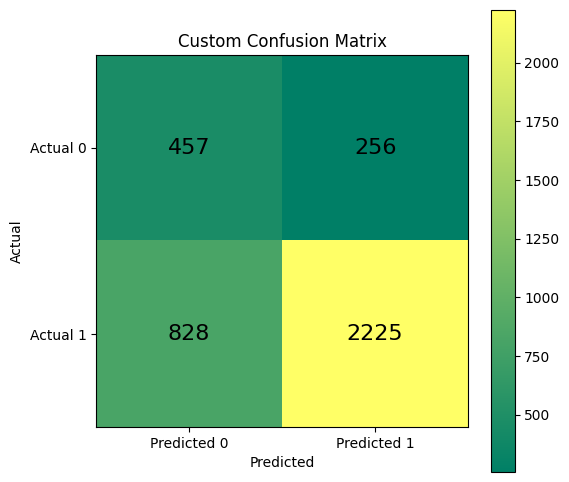

In [98]:
# 混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='summer')
plt.colorbar()
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), fontsize=16, ha='center', va='center')
plt.xticks([0, 1], labels=['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], labels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Custom Confusion Matrix')
plt.show()

In [94]:
# 計算並輸出性能指標
tp = conf_matrix[0, 0]
fn = conf_matrix[0, 1]
fp = conf_matrix[1, 0]
tn = conf_matrix[1, 1]
accuracy = (tp + tn) / (tp + fn + fp + tn)
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Accuracy: 0.7122
Sensitivity (Recall): 0.6410
Specificity: 0.7288
Precision: 0.3556
F1-Score: 0.4575


In [95]:
# 保存包含 Name、cycle、hands 等測試集資訊和模型預測結果的 CSV 檔案
new_data = pd.DataFrame({
    'Name': info_test['Name'].values,
    'Cycle': info_test['i'].values,
    'Hands': info_test['hands'].values,
    'Actual_Label': y_test.values,
    'Predicted_Label': y_pred
})

new_data = new_data.sort_values(by='Name')
new_data['Is_Correct'] = new_data['Actual_Label'] == new_data['Predicted_Label']

# 根據 Name 和 hands 分組計算正確和錯誤的數量
summary = new_data.groupby(['Name', 'Hands'])['Is_Correct'].value_counts().unstack().fillna(0)
summary.columns = ['Incorrect', 'Correct']
summary = summary.astype(int).reset_index()

# 保存至 CSV
summary.to_csv('F:\\All data\\Patient_Signal\\Classification_Summary.csv', index=False, encoding='utf-8-sig')
print("已儲存分類結果為 Classification_Summary.csv")


已儲存分類結果為 Classification_Summary.csv


In [96]:
# 將最終的 Actual_Label 和 Predicted_Label 的總結結果保存
final_summary = new_data.groupby('Name').agg(
    Actual_0_Count=('Actual_Label', lambda x: (x == 0).sum()),
    Actual_1_Count=('Actual_Label', lambda x: (x == 1).sum()),
    Predicted_0_Count=('Predicted_Label', lambda x: (x == 0).sum()),
    Predicted_1_Count=('Predicted_Label', lambda x: (x == 1).sum())
).reset_index()

# 判斷總體的預測結果
final_summary['Predicted_Label'] = final_summary.apply(lambda row: 0 if row['Predicted_0_Count'] > row['Predicted_1_Count'] else 1, axis=1)
final_summary['Actual_Label'] = final_summary.apply(lambda row: 0 if row['Actual_0_Count'] > row['Actual_1_Count'] else 1, axis=1)

# 保存總結至 CSV
final_summary.to_csv('F:\\All data\\Patient_Signal\\Final_Classification_Summary.csv', index=False, encoding='utf-8-sig')
print("已儲存最終分類結果為 Final_Classification_Summary.csv")

已儲存最終分類結果為 Final_Classification_Summary.csv


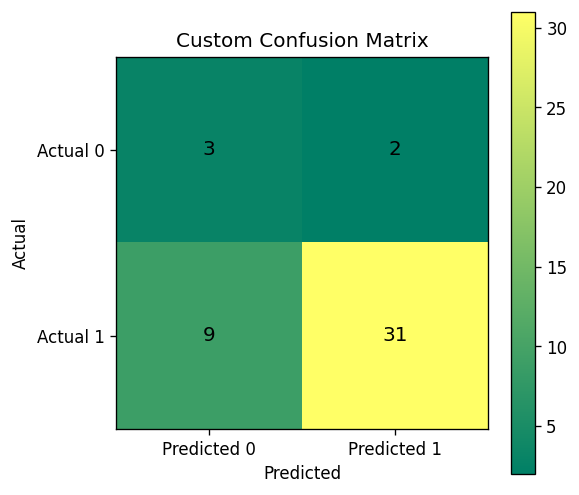

Accuracy: 0.7556
Sensitivity (Recall): 0.6000
Specificity: 0.7750
Precision: 0.2500
F1-Score: 0.3529


In [99]:
# 假設 conf_matrix 已經是你現有的混淆矩陣結果
conf_matrix = confusion_matrix(final_summary['Actual_Label'], final_summary['Predicted_Label'])

# 繪製自定義混淆矩陣
plt.figure(figsize=(5, 5), dpi=120)
plt.imshow(conf_matrix, cmap='summer')
plt.colorbar()

# 在混淆矩陣中新增文字
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), fontsize=12,
                 horizontalalignment='center', verticalalignment='center')

# 設定軸刻度和標籤
plt.xticks(np.arange(0, 2), ['Predicted 0', 'Predicted 1'])  # x軸刻度標籤
plt.yticks(np.arange(0, 2), ['Actual 0', 'Actual 1'])        # y軸刻度標籤
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Custom Confusion Matrix')
plt.show()
# 7. 計算性能指標
tp = conf_matrix[0, 0]
fn = conf_matrix[0, 1]
fp = conf_matrix[1, 0]
tn = conf_matrix[1, 1]
accuracy = (tp + tn) / (tp + fn + fp + tn) if (tp + fn + fp + tn) != 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

# 8. 輸出結果
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")